In [1]:
import os
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-11-24 22:29:18.500084: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-24 22:29:18.694804: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-24 22:29:19.560633: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/lib/x86_64-linux-gnu/:/opt/conda/lib
2024-11-24 22:29:19.560768: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] 

In [2]:
# Define paths
root_dir = './Data Files'    # CHANGE BASED ON FOLDER LOCATION
sub_folder = 'short axis frames'
dataframe_path = './Data Files/new_image_labels_gcp.csv'  # Update the path

In [3]:
 # Load DataFrames
original_data = pd.DataFrame()
for video_folder in os.listdir(os.path.join(root_dir, sub_folder)):
    video_path = os.path.join(root_dir, sub_folder, video_folder)
    if os.path.isdir(video_path):
        label_file = os.path.join(root_dir, 'shortaxis_binary v2.xlsx')
        try:
            labels_df = pd.read_excel(label_file, sheet_name=video_folder)
        except ValueError:
            continue
        
        for img_filename in os.listdir(video_path):
            if img_filename.endswith(".jpg"):
                img_path = os.path.join(video_path, img_filename)
                frame_idx = int(os.path.splitext(img_filename)[0].split('_')[-1])
                labels = labels_df.loc[frame_idx, ['BAD QUALITY', 'CORD', 'FLUID']].values.astype('float32')
                new_data = {
                    'FILENAME': img_path,
                    'BAD QUALITY': labels[0],
                    'CORD': labels[1],
                    'FLUID': labels[2]}
                original_data = pd.concat([original_data, pd.DataFrame(new_data, index=[0])], axis=0)

new_data = pd.read_csv(dataframe_path)

# Combine datasets
combined_data = pd.concat([original_data, new_data], ignore_index=True)

# Split datasets
train_data, temp_data = train_test_split(combined_data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.25, random_state=42)

# Define ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1.0 / 255, rotation_range=15, zoom_range=0.2, horizontal_flip=True)
val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Helper function to create generators
def create_generator(datagen, dataframe, batch_size, target_size=(128, 128)):
    return datagen.flow_from_dataframe(
        dataframe,
        x_col='FILENAME',
        y_col=['BAD QUALITY', 'CORD', 'FLUID'],
        target_size=target_size,
        batch_size=batch_size,
        class_mode='raw',
        shuffle=False,
        validate_filenames = False
    )

# Create generators
batch_size = 8
train_generator = create_generator(train_datagen, train_data, batch_size)
val_generator = create_generator(val_test_datagen, val_data, batch_size)
test_generator = create_generator(val_test_datagen, test_data, batch_size)

Found 3256 non-validated image filenames.
Found 611 non-validated image filenames.
Found 204 non-validated image filenames.


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Function to visualize samples
def visualize_samples(generator, title, num_samples=16):
    """
    Visualizes samples from a data generator.
    
    Args:
    - generator: The data generator (train, val, or test).
    - title: Title for the plot.
    - num_samples: Number of samples to display (default 16).
    """
    images, labels = next(generator)  # Fetch a batch of images and labels
    images = images[:num_samples]  # Select the first `num_samples` images
    labels = labels[:num_samples]  # Select the corresponding labels
    
    # Set up the figure
    fig, axes = plt.subplots(2, 4, figsize=(12, 12))  # 4x4 grid for 16 samples
    fig.suptitle(title, fontsize=16, y=0.92)

    for i, ax in enumerate(axes.flat):
        if i < len(images):
            img = images[i]
            lbl = labels[i]

            ax.imshow(img)
            lbl_text = ', '.join(f'{l:.2f}' for l in lbl)
            ax.set_title(lbl_text, fontsize=10)
            ax.axis('off')
        else:
            ax.axis('off')  # Turn off empty subplots

    plt.tight_layout()
    plt.show()

# Fetch a batch of data from each generator for visualization
train_sample_gen = train_generator
val_sample_gen = val_generator
test_sample_gen = test_generator

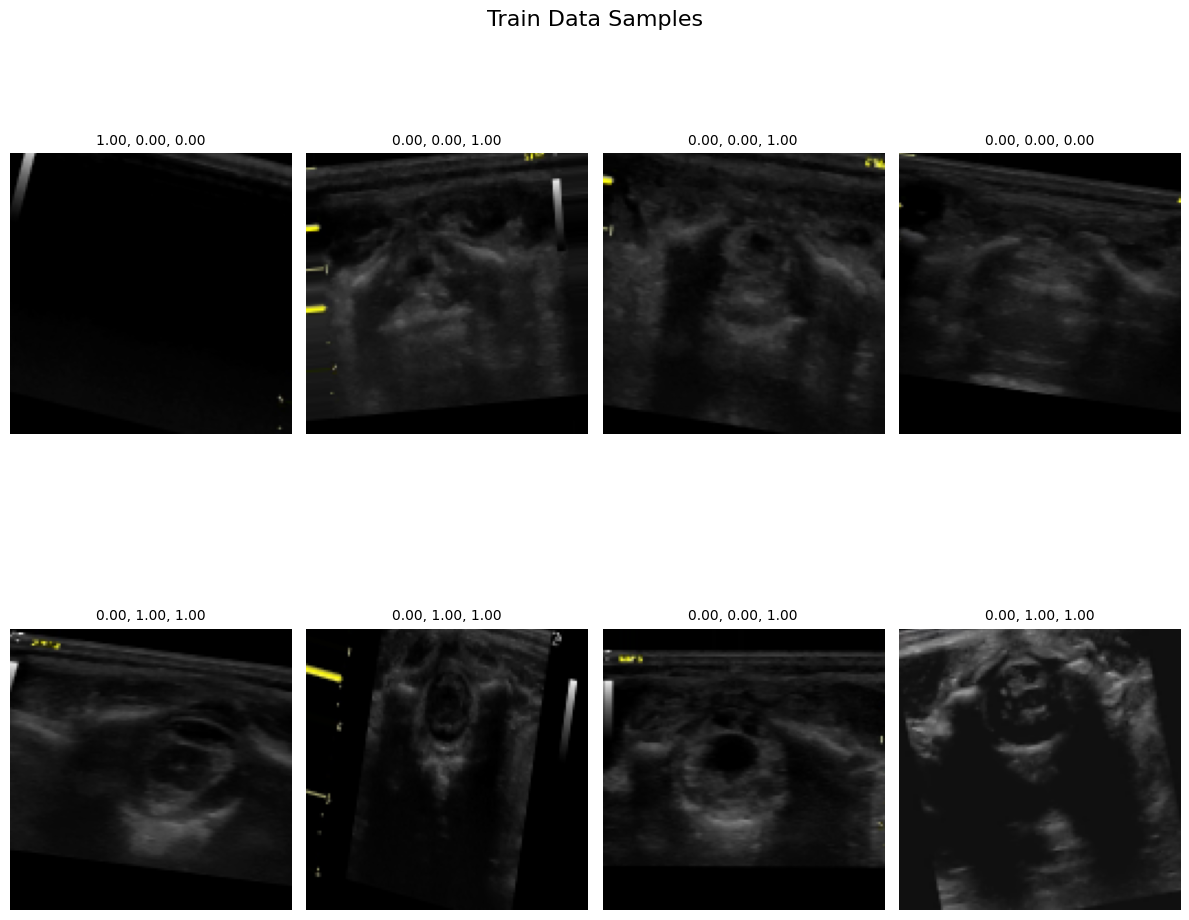

In [5]:
# Visualize samples
visualize_samples(train_sample_gen, "Train Data Samples")

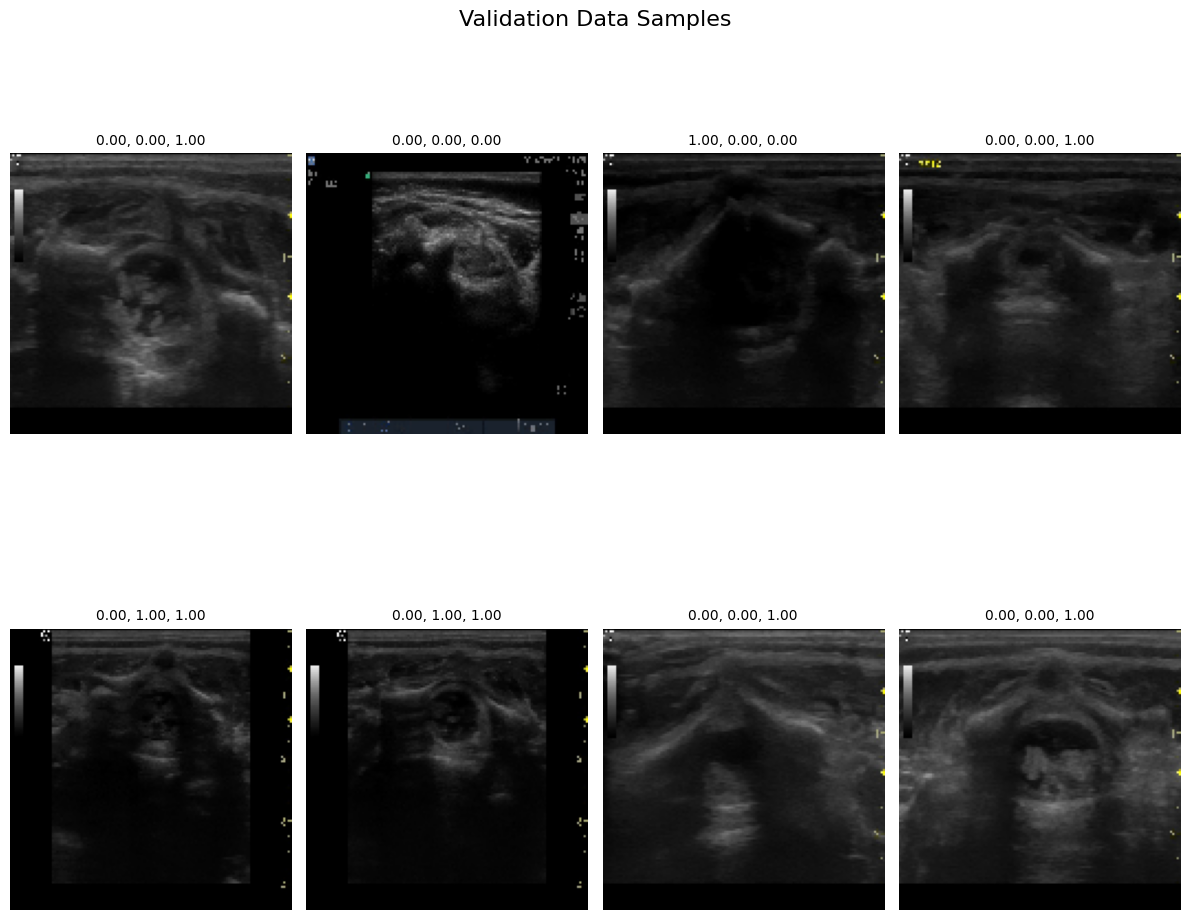

In [6]:
visualize_samples(val_sample_gen, "Validation Data Samples")

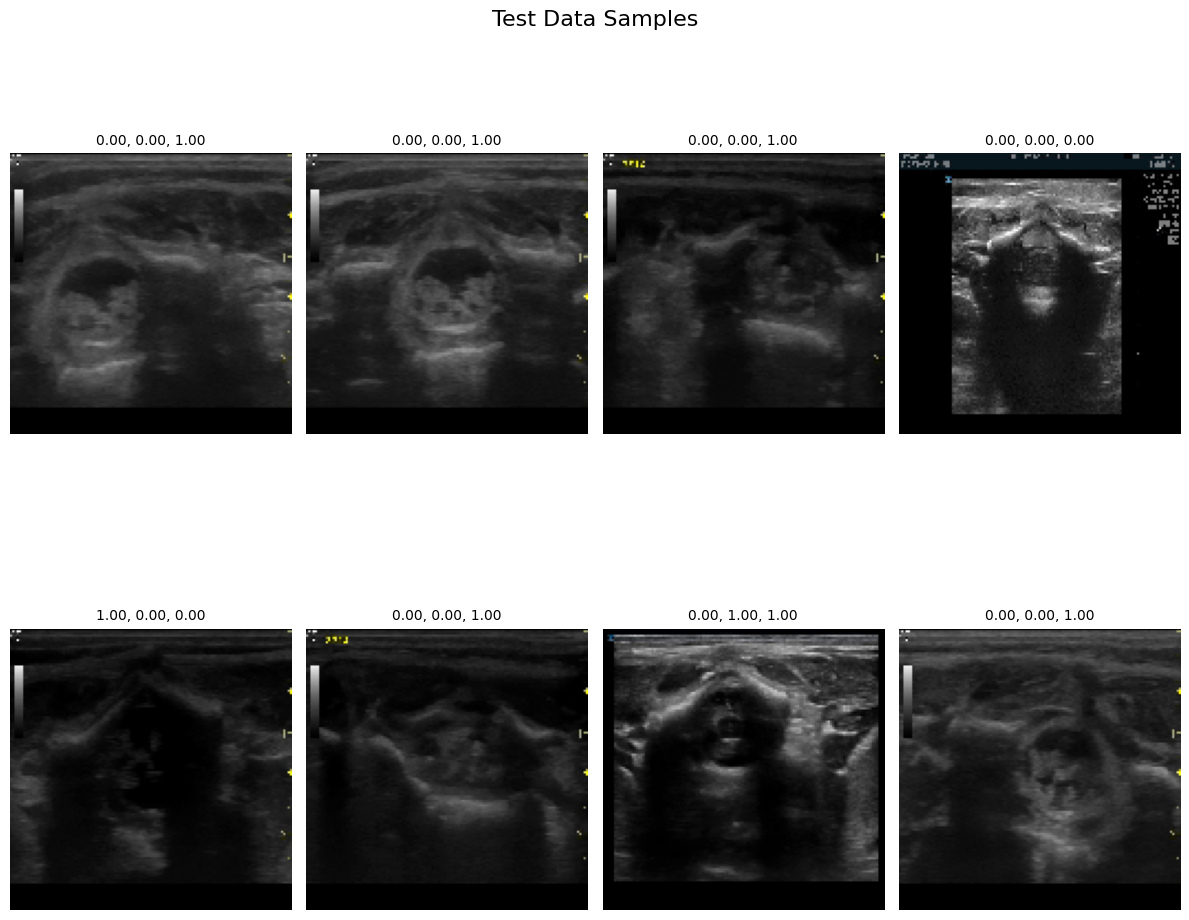

In [7]:
visualize_samples(test_sample_gen, "Test Data Samples")

In [8]:
train_sample_gen[0][0].shape

(8, 128, 128, 3)

In [9]:
from keras.layers import ConvLSTM2D, Dropout, Flatten, Dense
from keras.models import Sequential

In [10]:
import numpy as np

def create_sequence_generator(data_generator, time_steps, batch_size):
    """
    Transforms a data generator to output sequences for LSTM or TimeDistributed models.
    
    Args:
    - data_generator: Original data generator (e.g., train_generator).
    - time_steps: Number of frames in each sequence.
    - batch_size: Number of sequences per batch.
    
    Returns:
    - Generator yielding batches of sequences (batch_size, timesteps, height, width, channels) and labels.
    """
    # Buffer to store frames and labels for creating sequences
    frame_buffer = []
    label_buffer = []

    for batch_x, batch_y in data_generator:
        # Append frames and labels to the buffers
        for i in range(len(batch_x)):
            frame_buffer.append(batch_x[i])
            label_buffer.append(batch_y[i])

            # When we have enough frames to form a sequence
            if len(frame_buffer) >= time_steps:
                # Form a sequence
                sequence_x = np.array(frame_buffer[:time_steps])  # First `time_steps` frames
                sequence_y = np.array(label_buffer[time_steps - 1])  # Label of the last frame

                # Remove used frames and labels from the buffer
                frame_buffer.pop(0)
                label_buffer.pop(0)

                # Yield a batch of sequences
                yield (
                    np.expand_dims(sequence_x, axis=0),  # Add batch dimension
                    np.expand_dims(sequence_y, axis=0)   # Add batch dimension
                )

In [11]:
# Example: Test the output of the sequence generator
time_steps = 10  # Number of frames in a sequence
batch_size = 8

train_sequence_generator = create_sequence_generator(train_generator, time_steps, batch_size)
val_sequence_generator = create_sequence_generator(val_generator, time_steps, batch_size)

# Get one batch of data
sample_x, sample_y = next(train_sequence_generator)

print(f"Input shape: {sample_x.shape}")  # Expected: (batch_size, time_steps, height, width, channels)
print(f"Label shape: {sample_y.shape}")  # Expected: (batch_size, no_of_classes)

Input shape: (1, 10, 128, 128, 3)
Label shape: (1, 3)


In [12]:
time_steps = 3  # Define the number of frames per sequence
batch_size = 8

# Create sequence generators for train and validation
train_sequence_generator = create_sequence_generator(train_generator, time_steps, batch_size)
val_sequence_generator = create_sequence_generator(val_generator, time_steps, batch_size)

In [13]:
model = Sequential()
input_shape = (time_steps, 128, 128, 3)  # Include time_steps in input shape

model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), padding="same",
                     return_sequences=False, data_format="channels_last",
                     input_shape=input_shape))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(3, activation="sigmoid"))

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=["accuracy"])

2024-11-24 22:30:21.880075: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-24 22:30:21.916376: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-24 22:30:21.919843: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-24 22:30:21.923806: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 128, 128, 64)      154624    
                                                                 
 dropout (Dropout)           (None, 128, 128, 64)      0         
                                                                 
 flatten (Flatten)           (None, 1048576)           0         
                                                                 
 dense (Dense)               (None, 256)               268435712 
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 268,591,107
Trainable params: 268,591,107


In [15]:
# Train the model
model.fit(
    train_sequence_generator,
    validation_data=val_sequence_generator,
    epochs=10,
    steps_per_epoch=len(train_generator) // time_steps,
    validation_steps=len(val_generator) // time_steps
)

Epoch 1/10


2024-11-24 22:30:42.170477: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8900


135/135 [==============================] - 15s 88ms/step - loss: 1.3123 - accuracy: 0.5037 - val_loss: 2.7167 - val_accuracy: 0.4000
Epoch 2/10
135/135 [==============================] - 12s 86ms/step - loss: 1.1364 - accuracy: 0.5407 - val_loss: 1.6296 - val_accuracy: 0.2800
Epoch 3/10
135/135 [==============================] - 12s 86ms/step - loss: 0.9827 - accuracy: 0.5259 - val_loss: 0.6021 - val_accuracy: 0.6800
Epoch 4/10
135/135 [==============================] - 12s 86ms/step - loss: 0.5879 - accuracy: 0.5333 - val_loss: 0.5585 - val_accuracy: 0.4000
Epoch 5/10
135/135 [==============================] - 12s 86ms/step - loss: 0.5486 - accuracy: 0.5185 - val_loss: 0.5615 - val_accuracy: 0.5600
Epoch 6/10
135/135 [==============================] - 12s 86ms/step - loss: 0.5788 - accuracy: 0.5778 - val_loss: 0.3942 - val_accuracy: 0.5600
Epoch 7/10
135/135 [==============================] - 12s 86ms/step - loss: 0.5837 - accuracy: 0.5926 - val_loss: 0.5513 - val_accuracy: 0.3600
Epo

In [16]:
test_sequence_generator = create_sequence_generator(test_generator, time_steps, batch_size)

In [17]:
steps = 204//8
steps

25

In [18]:
model.evaluate(test_sequence_generator, steps=steps)

25/25 [==============================] - 0s 16ms/step - loss: 0.5147 - accuracy: 0.4400


[0.514687180519104, 0.4399999976158142]

In [19]:
predictions = model.predict(test_sequence_generator, steps=steps)

25/25 [==============================] - 1s 14ms/step
